**<center><h1>Cars Body Type Classification</h1></center>**

In this notebook, we are going to classify the cars based on the car's body type. So let's start.

In [2]:
# Install libraries
!pip install seedir
!pip install emoji
!pip install plotly
!pip install livelossplot

In [6]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seedir as sd
from zipfile import ZipFile
import plotly.express as px
import shutil
import cv2
import glob
from PIL import Image, ImageDraw
import json
import itertools
from itertools import cycle
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve, 
    auc,
    cohen_kappa_score,
    matthews_corrcoef,
    log_loss,
    fbeta_score
)

In [8]:
## deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, 
    Dense, 
    BatchNormalization, 
    Flatten, 
    Input, 
    Conv1D, 
    Conv2D, 
    MaxPooling2D, 
    Dropout
)
from keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2, EfficientNetV2S
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import efficientnet, EfficientNetV2L
from tensorflow.keras.applications.vgg19 import VGG19
from livelossplot.inputs.keras import PlotLossesCallback

In [9]:
train_car = glob.glob("/kaggle/input/cars-body-type-cropped/Cars_Body_Type/train/*/*")
test_car = glob.glob("/kaggle/input/cars-body-type-cropped/Cars_Body_Type/test/*/*")
valid_car = glob.glob("/kaggle/input/cars-body-type-cropped/Cars_Body_Type/valid/*/*")

In [10]:
#model_names = ["Convertible", "Coupe", "Hatchback", "Pick-Up", "SUV", "Sedan", "VAN"]
model_names = sorted(os.listdir('/kaggle/input/cars-body-type-cropped/Cars_Body_Type/train'))

In [11]:
## setting up some parameters for data augmentation
img_width, img_height = 224, 224
train_samples = len(train_car)
validation_samples = len(test_car)
testing_samples = len(valid_car)
## there are 196 different models
n_classes = len(model_names)
batch_size = 32

### **Data Augmentation**

In [12]:
"""train_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=(0.6, 1.0),
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')"""
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',)

test_datagen = ImageDataGenerator(rescale=1./255)

valid_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_path = "/kaggle/input/cars-body-type-cropped/Cars_Body_Type/train"
test_path = "/kaggle/input/cars-body-type-cropped/Cars_Body_Type/test"
valid_path = "/kaggle/input/cars-body-type-cropped/Cars_Body_Type/valid"

In [14]:
## converting data to a tf.data.Dataset object
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    classes=model_names,
    #subset='training',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42)                              

validation_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(img_width, img_height),
    classes=model_names,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42)

testing_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    class_mode=None,
    classes=model_names,
    batch_size=1,
    shuffle=False,
    seed=42)

Found 5350 images belonging to 7 classes.
Found 1397 images belonging to 7 classes.
Found 802 images belonging to 7 classes.


In [15]:
true_classes = testing_generator.classes
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

## **Transfer Learning**

In this part, we are going to use 2 transfer learning approaches:
* Feature Extraction Approach
* Fine-Tuning Approach

so let's write the functions that we are going to use in this part of the project:

In [24]:
def define_model(model_based, optimizer, fine_tune):
    base_model = model_based(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
    
    """if fine_tune > 0:
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in base_model.layers:
            layer.trainable = False"""
    
    for layer in base_model.layers:
        if isinstance(layer, BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False
            
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(250, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(7, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(),
                           #tf.keras.metrics.Recall(),
                           tf.keras.metrics.AUC()])
    
    return model

In [25]:
def train_model(epochs_num,model_to_train):
    
    plot_loss = PlotLossesCallback()
    
    model_history = model_to_train.fit(train_generator,
                                       batch_size=batch_size,
                                       epochs=epochs_num,
                                       validation_data=validation_generator,
                                       steps_per_epoch=train_generator.samples // batch_size ,
                                       validation_steps=validation_generator.samples // batch_size,
                                       #callbacks=[plot_loss],
                                       verbose=1)
    return model_history

In [26]:
def evaluate_model(model_to_evaluate):
    model_results = model_to_evaluate.evaluate(testing_generator)

In [27]:
def view_plots(history_model, epochs_num):
    
    acc_2 = history_model.history['accuracy']
    val_acc_2 = history_model.history['val_accuracy']
    loss_2 = history_model.history['loss']
    val_loss_2 = history_model.history['val_loss']
    epochs_range = range(epochs_num)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc_2, label='Training Accuracy')
    plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss_2, label='Training Loss')
    plt.plot(epochs_range, val_loss_2, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [28]:
def view_performance(trained_model):
    model_preds = trained_model.predict(testing_generator)
    model_pred_classes = np.argmax(model_preds, axis=-1)
    
    class_names = model_names
    
    # Show evaluation metrics
    #model_preds_probs = trained_model.predict_proba(testing_generator)
    #print("ROC AUC score:", roc_auc_score(true_classes, model_preds_probs, average="weighted", multi_class="ovr"))
    print("Cohen’s Kappa score:", cohen_kappa_score(true_classes, model_pred_classes))
    print("Matthew’s correlation coefficient:", matthews_corrcoef(true_classes, model_pred_classes))
    #print("Log loss", log_loss(true_classes, model_preds_probs))
    #print("F-beta score", fbeta_score(true_classes, model_pred_classes, beta=7))
    
    
    # Create a classification report
    print("classification report:")
    print('\n', classification_report(true_classes, model_pred_classes, target_names=model_names), sep='') 

    # Display a confusion matrix
    print("confusion matric:")
    cm = confusion_matrix(true_classes, model_pred_classes) 
    cm_df = pd.DataFrame(cm,
                     index = model_names, 
                     columns = model_names)

    plt.figure(figsize=(14.8,8))
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # Display ROC-AUC Curve
    true_labels = testing_generator.classes 
    #model_preds = trained_model.predict(testing_generator)

    n_classes = len(np.unique(true_labels))
    true_labels_bin = label_binarize(true_labels, classes=np.arange(n_classes))
    
    n_classes = 7
    true_labels_bin = label_binarize(true_labels, classes=np.arange(n_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for class_idx in range(n_classes):
        fpr[class_idx], tpr[class_idx], _ = roc_curve(true_labels_bin[:, class_idx], model_preds[:, class_idx])
        roc_auc[class_idx] = auc(fpr[class_idx], tpr[class_idx])

    plt.figure(figsize=(7, 5))
    colors = cycle(['blue', 'red', 'green', 'purple', 'orange'])  
    for class_idx, color in zip(range(n_classes), colors):
        plt.plot(fpr[class_idx], tpr[class_idx], color=color, lw=2,
                 label='Class {} (AUC = {:.2f})'.format(class_names[class_idx], roc_auc[class_idx]))

    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')  
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multiclass Classification')
    plt.legend(loc="lower right")
    plt.show()
    
    # Show F-beta Scroe
    true_labels_bin = label_binarize(true_labels, classes=np.arange(7))

    # Step 4: Calculate the F-beta score for each class
    beta = 0.5  # Set the value of beta for F-beta score calculation
    f_beta_scores = []

    for class_idx in range(7):
        true_labels_class = true_labels_bin[:, class_idx]
        pred_labels_class = model_preds[:, class_idx] >= 0.5  # Binary prediction for the class (adjust threshold as needed)
        f_beta = fbeta_score(true_labels_class, pred_labels_class, beta=beta)
        f_beta_scores.append(f_beta)

    # Step 5: Average F-beta score across all classes
    avg_f_beta = np.mean(f_beta_scores)

    # Print the F-beta score for each class and the average F-beta score
    for class_idx, f_beta in enumerate(f_beta_scores):
        print('Class {}: F-beta score = {:.4f}'.format(class_names[class_idx], f_beta))
    print('Average F-beta score: {:.4f}'.format(avg_f_beta))

In [29]:
def plot_predictions(model, y_true, test_generator, class_indices):
    model_preds = model.predict(testing_generator)
    y_preds = np.argmax(model_preds, axis=-1)
    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("Prediction: {}\n True;({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

### **Resnet50**

In [37]:
ResNet50_Compiled = define_model(model_based=tf.keras.applications.resnet50.ResNet50, optimizer=tf.keras.optimizers.Adam(lr=0.0001), fine_tune=30)

In [38]:
ResNet50_History = train_model(epochs_num=80, model_to_train=ResNet50_Compiled)

Epoch 1/80
167/167 [==============================] - 131s 572ms/step - loss: 1.3833 - accuracy: 0.4756 - precision_2: 0.6521 - auc_2: 0.8339 - val_loss: 2.6164 - val_accuracy: 0.2093 - val_precision_2: 0.2228 - val_auc_2: 0.5388
Epoch 2/80
167/167 [==============================] - 94s 565ms/step - loss: 0.8488 - accuracy: 0.6719 - precision_2: 0.7757 - auc_2: 0.9398 - val_loss: 3.2268 - val_accuracy: 0.2115 - val_precision_2: 0.2091 - val_auc_2: 0.5233
Epoch 3/80
167/167 [==============================] - 95s 571ms/step - loss: 0.7429 - accuracy: 0.7117 - precision_2: 0.7871 - auc_2: 0.9534 - val_loss: 2.1610 - val_accuracy: 0.2834 - val_precision_2: 0.4348 - val_auc_2: 0.6208
Epoch 4/80
167/167 [==============================] - 94s 563ms/step - loss: 0.6577 - accuracy: 0.7586 - precision_2: 0.8165 - auc_2: 0.9633 - val_loss: 1.6190 - val_accuracy: 0.4542 - val_precision_2: 0.5138 - val_auc_2: 0.8259
Epoch 5/80
167/167 [==============================] - 99s 591ms/step - loss: 0.5869

In [39]:
evaluate_model(model_to_evaluate=ResNet50_Compiled)

802/802 [==============================] - 8s 9ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision_2: 0.0000e+00 - auc_2: 0.0000e+00


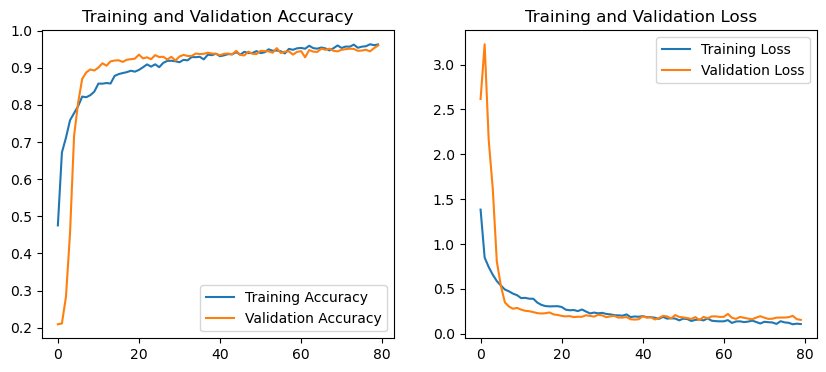

In [40]:
view_plots(history_model=ResNet50_History, epochs_num=80)

802/802 [==============================] - 10s 11ms/step
Cohen’s Kappa score: 0.9427203703635878
Matthew’s correlation coefficient: 0.9428619646150391
classification report:

              precision    recall  f1-score   support

 Convertible       0.99      0.98      0.98       174
       Coupe       0.94      0.91      0.92        79
   Hatchback       0.93      0.86      0.89        99
     Pick-Up       0.97      0.98      0.98       110
         SUV       0.95      0.94      0.95       125
       Sedan       0.88      0.95      0.92       109
         VAN       0.97      1.00      0.99       106

    accuracy                           0.95       802
   macro avg       0.95      0.95      0.95       802
weighted avg       0.95      0.95      0.95       802

confusion matric:


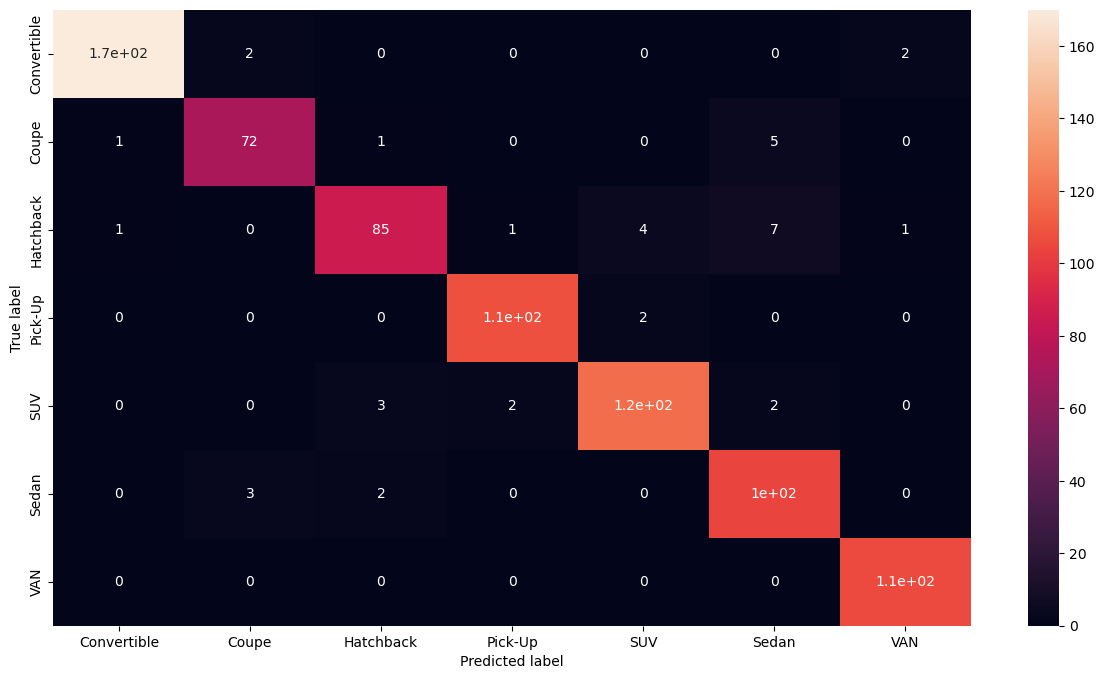

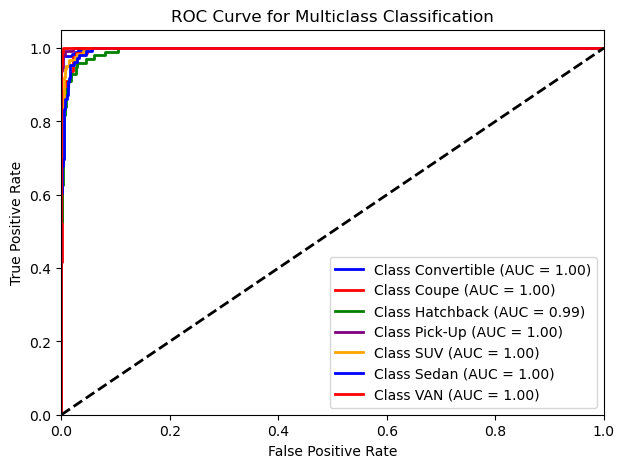

Class Convertible: F-beta score = 0.9861
Class Coupe: F-beta score = 0.9302
Class Hatchback: F-beta score = 0.9179
Class Pick-Up: F-beta score = 0.9747
Class SUV: F-beta score = 0.9501
Class Sedan: F-beta score = 0.8950
Class VAN: F-beta score = 0.9779
Average F-beta score: 0.9474


In [41]:
view_performance(ResNet50_Compiled)

802/802 [==============================] - 9s 12ms/step


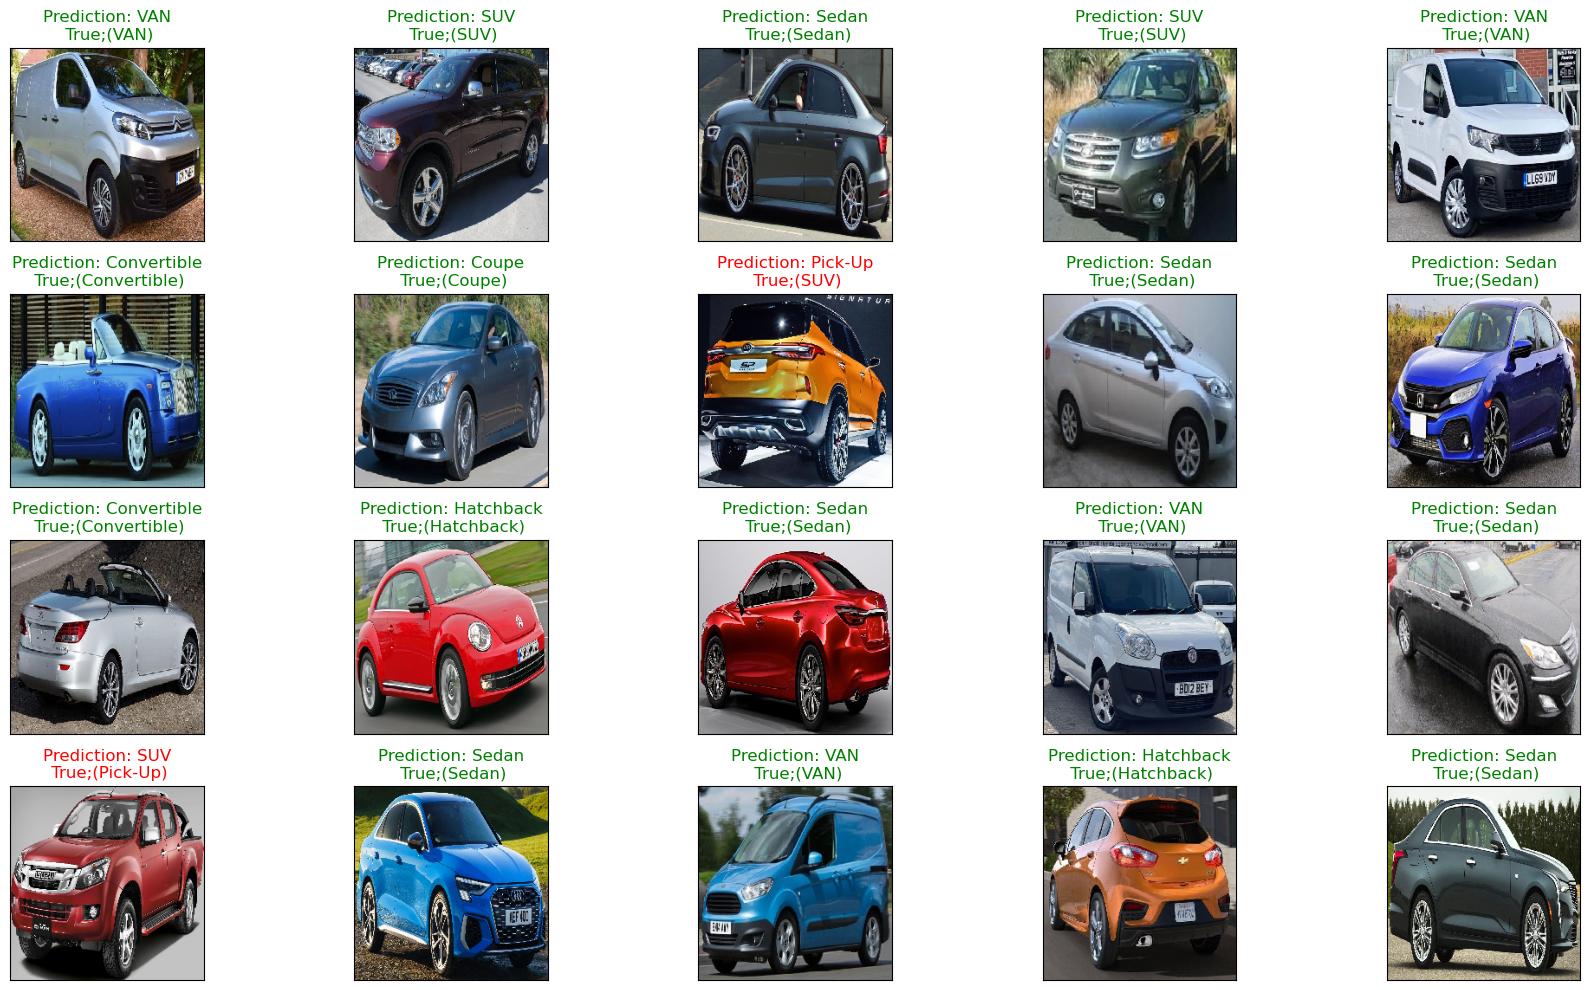

In [42]:
plot_predictions(ResNet50_Compiled, testing_generator.classes, testing_generator, class_indices)

### **EfficientNetB7**

In [43]:
EfficientNetB7_Compiled = define_model(model_based=efficientnet.EfficientNetB7, optimizer=tf.keras.optimizers.Adam(lr=0.0001), fine_tune=30)

258076736/258076736 [==============================] - 11s 0us/step


In [44]:
EfficientNetB7_History = train_model(epochs_num=80, model_to_train=EfficientNetB7_Compiled)

Epoch 1/80


2023-07-03 16:41:03.810030: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


167/167 [==============================] - 223s 872ms/step - loss: 1.3869 - accuracy: 0.4748 - precision_3: 0.6907 - auc_3: 0.8305 - val_loss: 2.6391 - val_accuracy: 0.0778 - val_precision_3: 0.0385 - val_auc_3: 0.4603
Epoch 2/80
167/167 [==============================] - 141s 840ms/step - loss: 0.9731 - accuracy: 0.6279 - precision_3: 0.7308 - auc_3: 0.9205 - val_loss: 2.1493 - val_accuracy: 0.2493 - val_precision_3: 0.4820 - val_auc_3: 0.5962
Epoch 3/80
167/167 [==============================] - 150s 897ms/step - loss: 0.7717 - accuracy: 0.7097 - precision_3: 0.7880 - auc_3: 0.9499 - val_loss: 0.7899 - val_accuracy: 0.6948 - val_precision_3: 0.7675 - val_auc_3: 0.9473
Epoch 4/80
167/167 [==============================] - 151s 901ms/step - loss: 0.6462 - accuracy: 0.7593 - precision_3: 0.8127 - auc_3: 0.9643 - val_loss: 0.4865 - val_accuracy: 0.8140 - val_precision_3: 0.8591 - val_auc_3: 0.9786
Epoch 5/80
167/167 [==============================] - 151s 902ms/step - loss: 0.5660 - accu

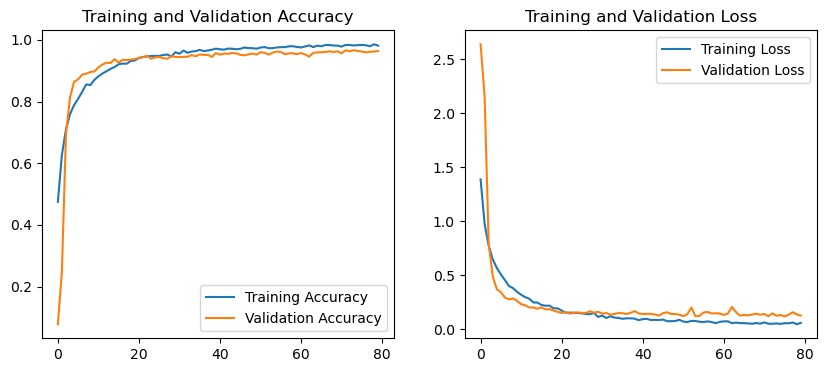

In [45]:
view_plots(history_model=EfficientNetB7_History, epochs_num=80)

802/802 [==============================] - 29s 30ms/step
Cohen’s Kappa score: 0.9486036751942697
Matthew’s correlation coefficient: 0.9486610043276269
classification report:

              precision    recall  f1-score   support

 Convertible       0.98      0.98      0.98       174
       Coupe       0.87      0.92      0.90        79
   Hatchback       0.97      0.91      0.94        99
     Pick-Up       0.97      0.99      0.98       110
         SUV       0.96      0.95      0.96       125
       Sedan       0.93      0.93      0.93       109
         VAN       0.98      0.98      0.98       106

    accuracy                           0.96       802
   macro avg       0.95      0.95      0.95       802
weighted avg       0.96      0.96      0.96       802

confusion matric:


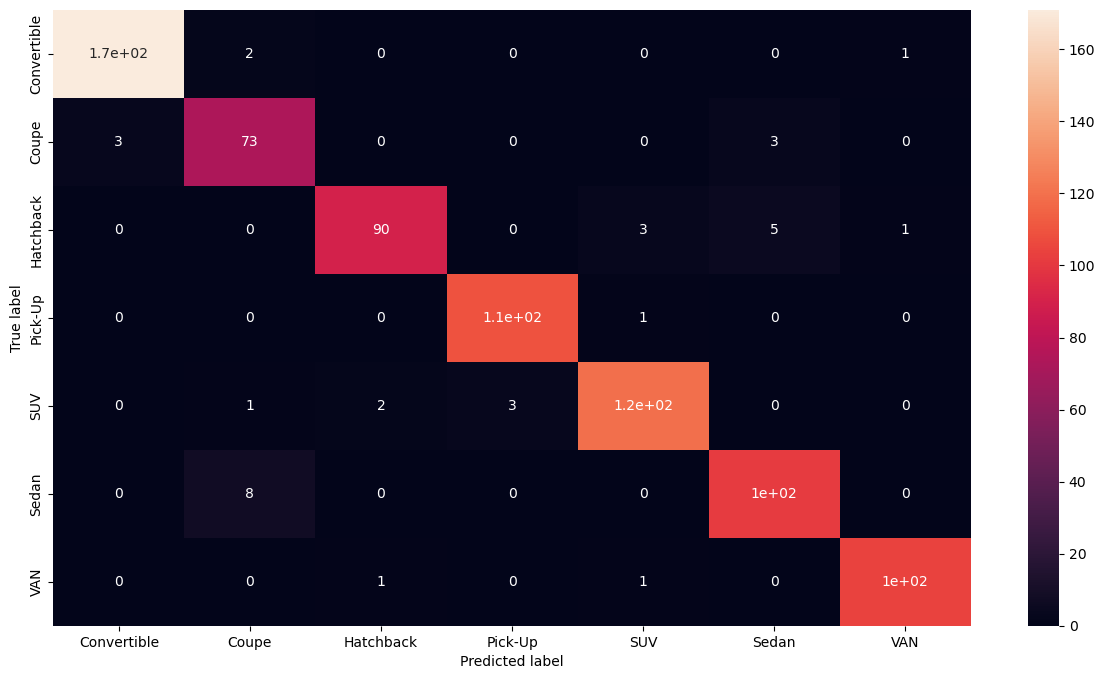

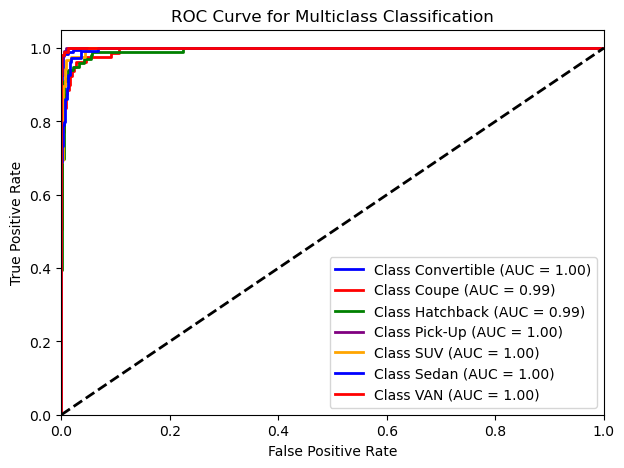

Class Convertible: F-beta score = 0.9828
Class Coupe: F-beta score = 0.8795
Class Hatchback: F-beta score = 0.9554
Class Pick-Up: F-beta score = 0.9767
Class SUV: F-beta score = 0.9562
Class Sedan: F-beta score = 0.9266
Class VAN: F-beta score = 0.9811
Average F-beta score: 0.9512


In [46]:
view_performance(EfficientNetB7_Compiled)

802/802 [==============================] - 23s 29ms/step


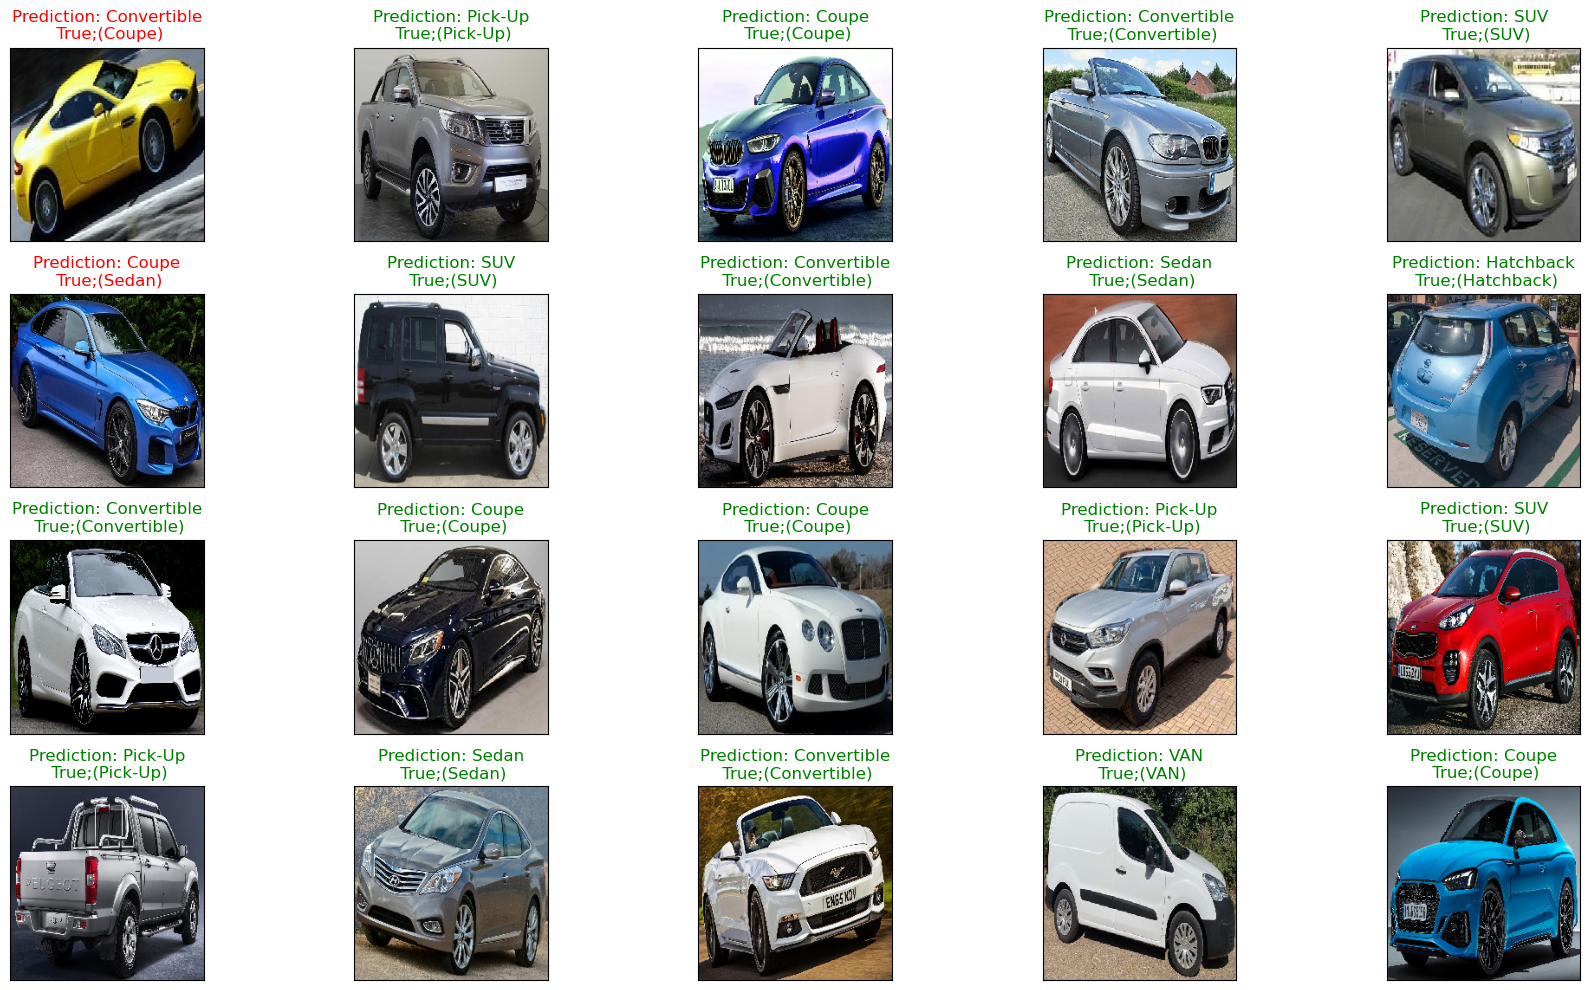

In [47]:
plot_predictions(EfficientNetB7_Compiled, testing_generator.classes, testing_generator, class_indices)

### **Xception**

In [48]:
Xception_Compiled = define_model(model_based=tf.keras.applications.Xception, optimizer=tf.keras.optimizers.Adam(lr=0.0001), fine_tune=30)

83683744/83683744 [==============================] - 4s 0us/step


In [49]:
Xception_History = train_model(epochs_num=80, model_to_train=Xception_Compiled)

Epoch 1/80
167/167 [==============================] - 120s 614ms/step - loss: 1.2414 - accuracy: 0.5267 - precision_4: 0.7294 - auc_4: 0.8668 - val_loss: 0.6461 - val_accuracy: 0.7478 - val_precision_4: 0.7743 - val_auc_4: 0.9647
Epoch 2/80
167/167 [==============================] - 110s 656ms/step - loss: 0.7311 - accuracy: 0.7230 - precision_4: 0.7955 - auc_4: 0.9548 - val_loss: 0.4073 - val_accuracy: 0.8452 - val_precision_4: 0.8758 - val_auc_4: 0.9855
Epoch 3/80
167/167 [==============================] - 99s 591ms/step - loss: 0.5979 - accuracy: 0.7775 - precision_4: 0.8315 - auc_4: 0.9693 - val_loss: 0.3378 - val_accuracy: 0.8866 - val_precision_4: 0.9117 - val_auc_4: 0.9901
Epoch 4/80
167/167 [==============================] - 100s 597ms/step - loss: 0.5243 - accuracy: 0.7997 - precision_4: 0.8442 - auc_4: 0.9757 - val_loss: 0.3129 - val_accuracy: 0.8852 - val_precision_4: 0.9040 - val_auc_4: 0.9909
Epoch 5/80
167/167 [==============================] - 99s 592ms/step - loss: 0.47

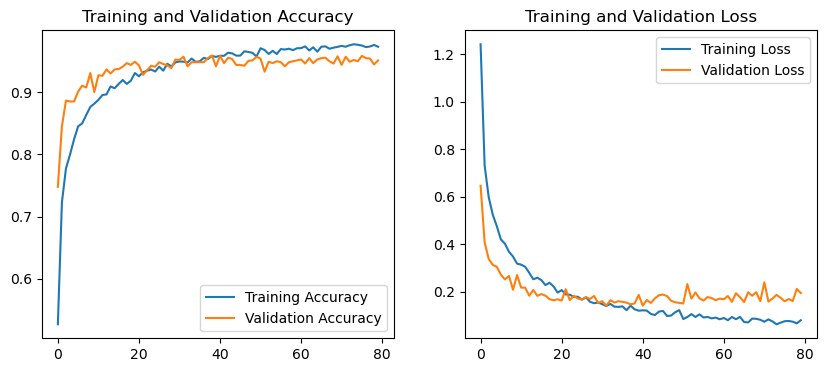

In [50]:
view_plots(history_model=Xception_History, epochs_num=80)

802/802 [==============================] - 9s 11ms/step
Cohen’s Kappa score: 0.9368713171426427
Matthew’s correlation coefficient: 0.9370445931124849
classification report:

              precision    recall  f1-score   support

 Convertible       0.99      0.98      0.98       174
       Coupe       0.92      0.87      0.90        79
   Hatchback       0.87      0.94      0.90        99
     Pick-Up       0.97      0.97      0.97       110
         SUV       0.97      0.90      0.93       125
       Sedan       0.89      0.94      0.91       109
         VAN       0.99      1.00      1.00       106

    accuracy                           0.95       802
   macro avg       0.94      0.94      0.94       802
weighted avg       0.95      0.95      0.95       802

confusion matric:


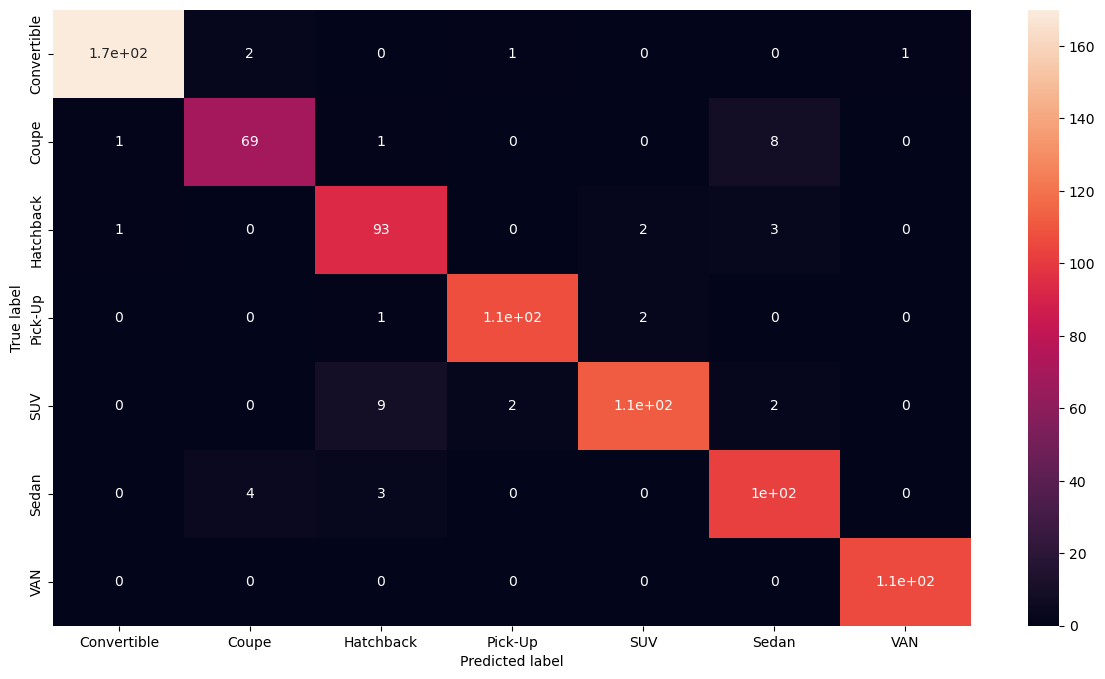

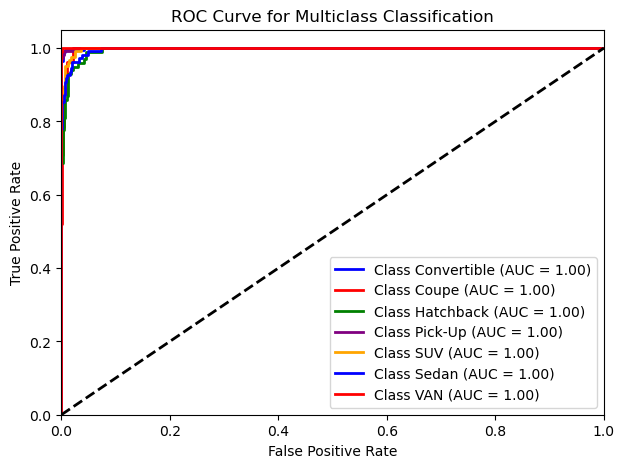

Class Convertible: F-beta score = 0.9861
Class Coupe: F-beta score = 0.9103
Class Hatchback: F-beta score = 0.8824
Class Pick-Up: F-beta score = 0.9799
Class SUV: F-beta score = 0.9508
Class Sedan: F-beta score = 0.9091
Class VAN: F-beta score = 0.9925
Average F-beta score: 0.9444


In [51]:
view_performance(Xception_Compiled)

802/802 [==============================] - 8s 10ms/step


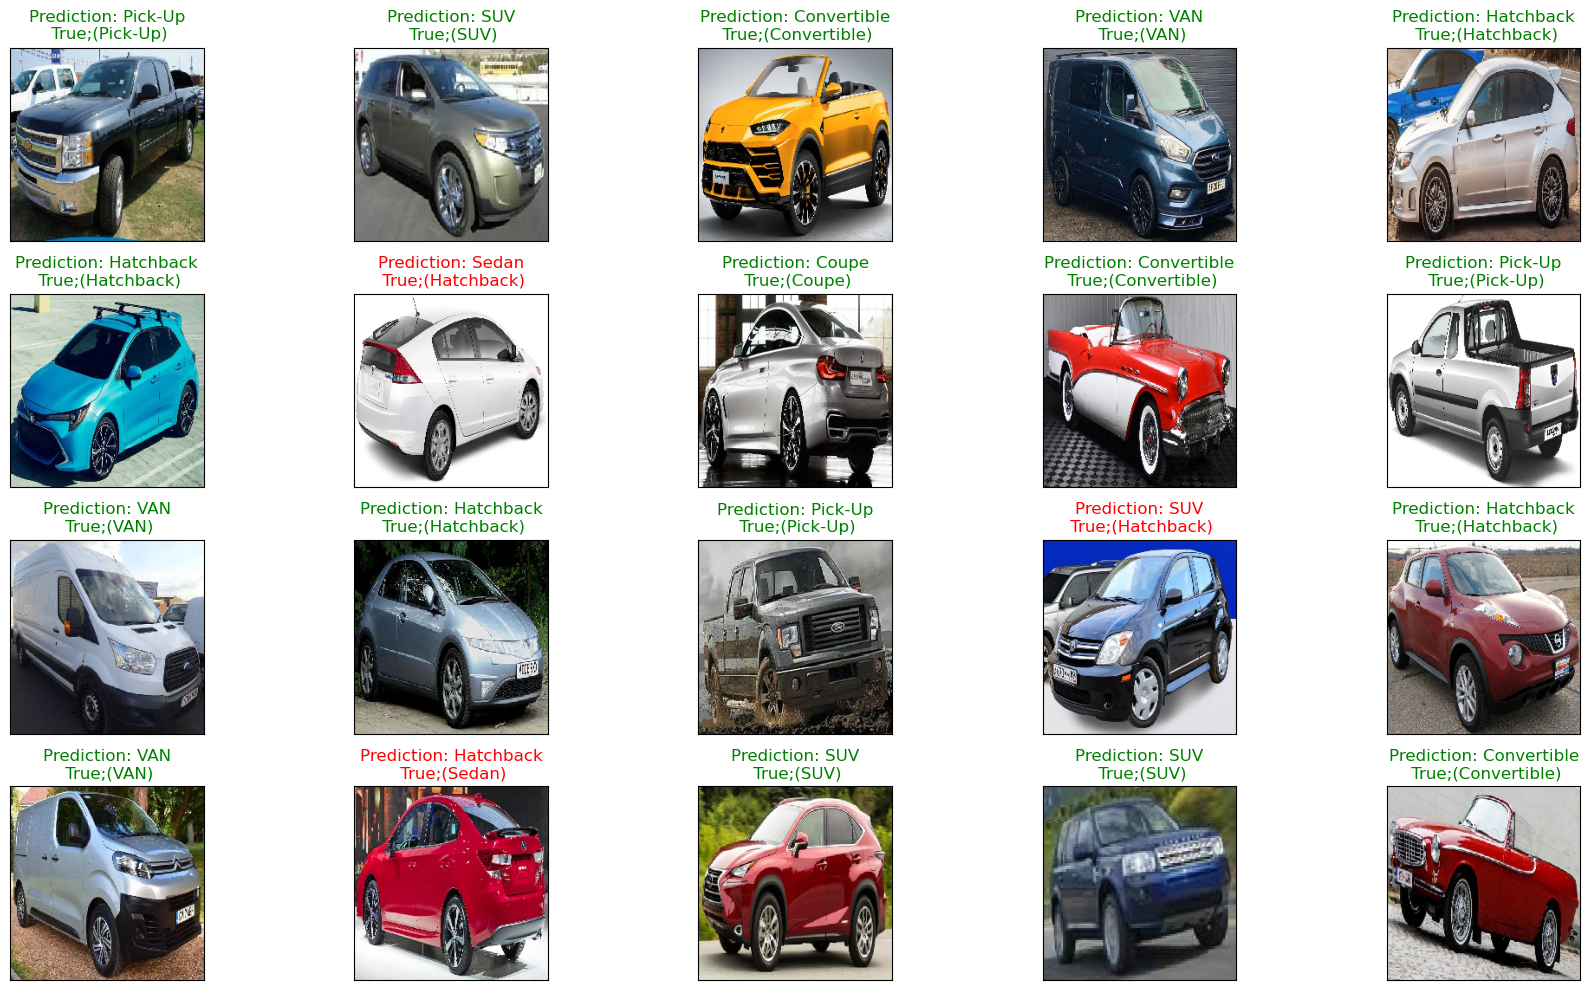

In [52]:
plot_predictions(Xception_Compiled, testing_generator.classes, testing_generator, class_indices)

### **VGG16**

In [31]:
VGG16_Compiled = define_model(model_based=tf.keras.applications.VGG16, optimizer=tf.keras.optimizers.Adam(lr=0.0001), fine_tune=30)


58889256/58889256 [==============================] - 1s 0us/step


In [32]:
VGG16_History = train_model(epochs_num=20, model_to_train=VGG16_Compiled)

Epoch 1/20

167/167 [==============================] - 109s 616ms/step - loss: 1.8179 - accuracy: 0.2832 - precision_2: 0.4861 - auc_2: 0.6668 - val_loss: 1.4520 - val_accuracy: 0.5807 - val_precision_2: 1.0000 - val_auc_2: 0.8895

Epoch 2/20

167/167 [==============================] - 101s 605ms/step - loss: 1.4362 - accuracy: 0.4652 - precision_2: 0.8029 - auc_2: 0.8342 - val_loss: 1.2091 - val_accuracy: 0.5778 - val_precision_2: 0.8516 - val_auc_2: 0.8994

Epoch 3/20

167/167 [==============================] - 103s 620ms/step - loss: 1.2521 - accuracy: 0.5354 - precision_2: 0.7671 - auc_2: 0.8743 - val_loss: 1.0623 - val_accuracy: 0.6352 - val_precision_2: 0.8947 - val_auc_2: 0.9218

Epoch 4/20

167/167 [==============================] - 101s 602ms/step - loss: 1.1583 - accuracy: 0.5668 - precision_2: 0.7623 - auc_2: 0.8917 - val_loss: 0.9340 - val_accuracy: 0.6904 - val_precision_2: 0.8962 - val_auc_2: 0.9391

Epoch 5/20

167/167 [==============================] - 101s 602ms/step -

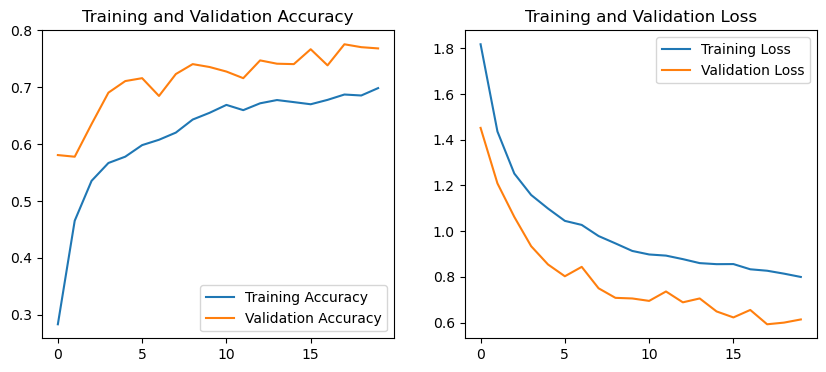

In [33]:
view_plots(history_model=VGG16_History, epochs_num=20)

802/802 [==============================] - 10s 11ms/step

Cohen’s Kappa score: 0.7026184322285443

Matthew’s correlation coefficient: 0.7045849748011693

classification report:



              precision    recall  f1-score   support



 Convertible       0.90      0.87      0.89       174

       Coupe       0.50      0.67      0.57        79

   Hatchback       0.71      0.48      0.57        99

     Pick-Up       0.79      0.87      0.83       110

         SUV       0.75      0.58      0.66       125

       Sedan       0.60      0.70      0.65       109

         VAN       0.88      0.96      0.92       106



    accuracy                           0.75       802

   macro avg       0.73      0.73      0.73       802

weighted avg       0.76      0.75      0.74       802



confusion matric:


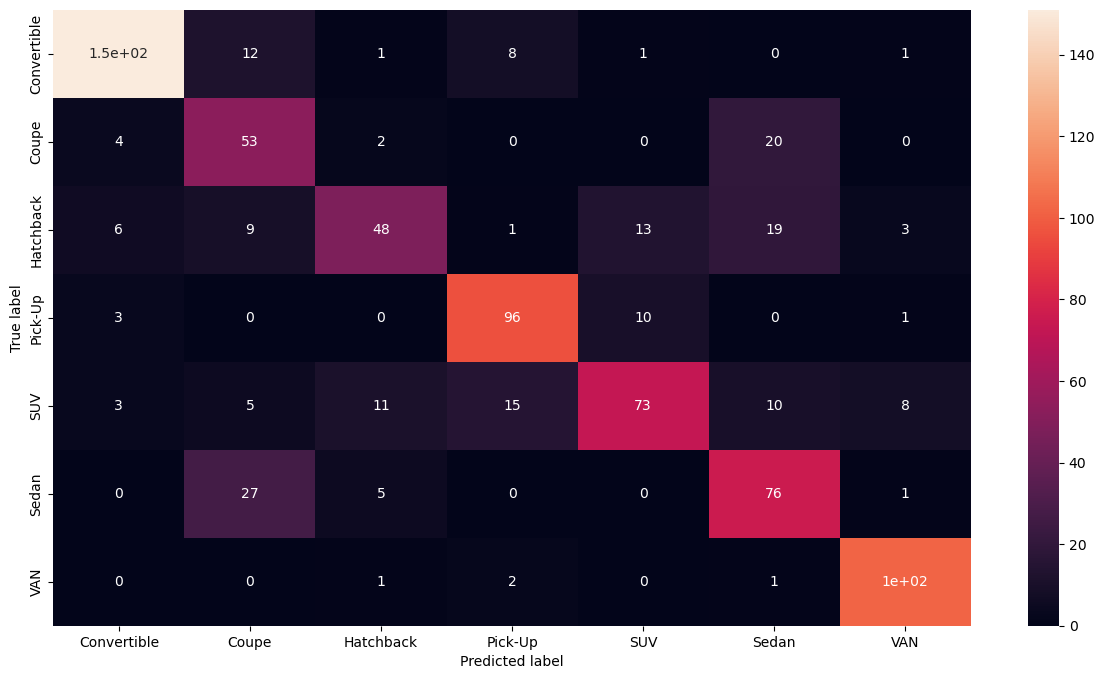

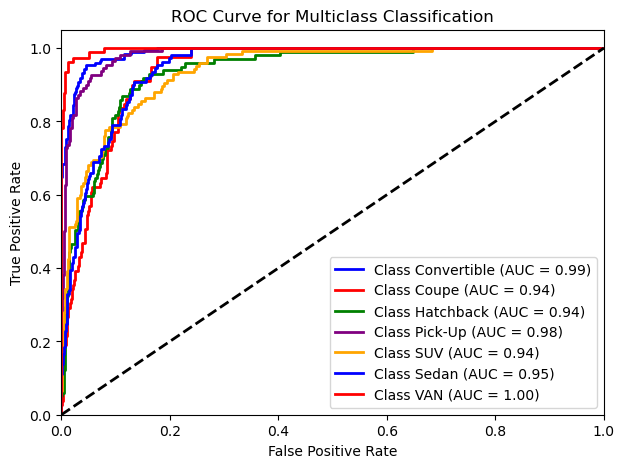

Class Convertible: F-beta score = 0.8987

Class Coupe: F-beta score = 0.5370

Class Hatchback: F-beta score = 0.6364

Class Pick-Up: F-beta score = 0.8333

Class SUV: F-beta score = 0.7529

Class Sedan: F-beta score = 0.6660

Class VAN: F-beta score = 0.9340

Average F-beta score: 0.7512


In [34]:
view_performance(VGG16_Compiled)

802/802 [==============================] - 9s 11ms/step


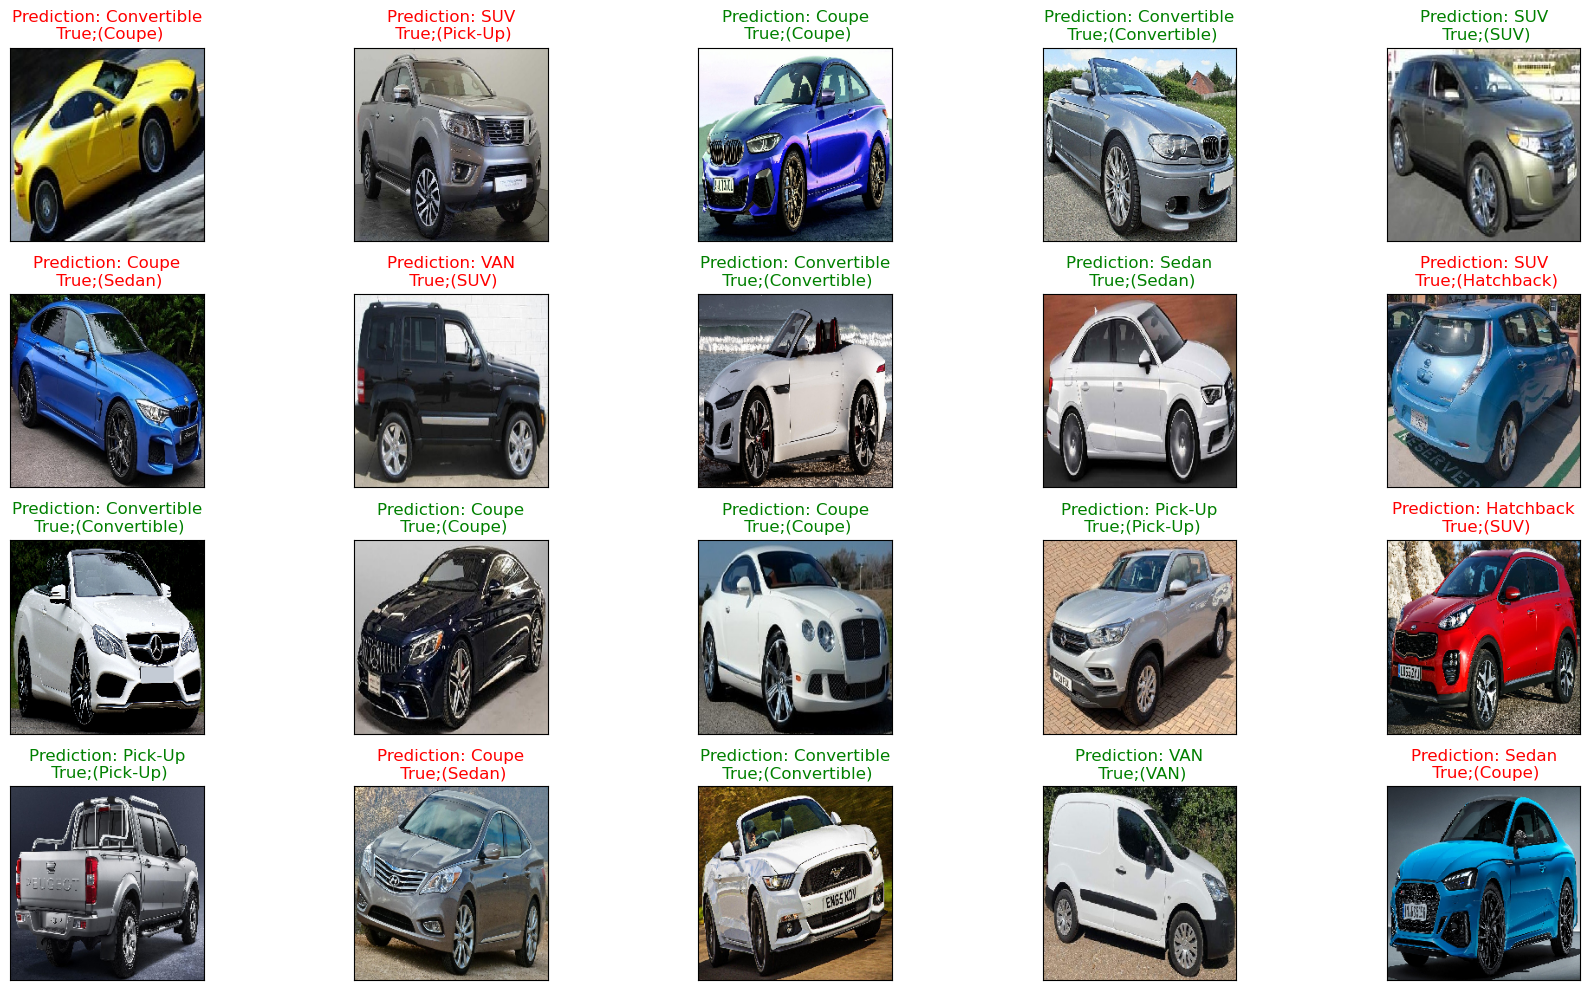

In [35]:
plot_predictions(VGG16_Compiled, testing_generator.classes, testing_generator, class_indices)